In [1]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.0/322.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [2]:
#!pip install transformers

In [3]:
# Importing Libraries
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import pipeline

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [5]:
import gradio as gr
#from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image

In [6]:
# setting an environment variable
os.environ['image_data'] = r'/content'

In [7]:
# Downloading the dataset from kaggle
!kaggle datasets download kunalgupta2616/flickr-8k-images-with-captions

Dataset URL: https://www.kaggle.com/datasets/kunalgupta2616/flickr-8k-images-with-captions
License(s): GPL-2.0
 99% 1.02G/1.04G [00:09<00:00, 166MB/s]
100% 1.04G/1.04G [00:09<00:00, 120MB/s]


In [8]:
# Extracting files from the downloaded ZIP file (/content/flickr-8k-images-with-captions.zip)
import zipfile
with zipfile.ZipFile("/content/flickr-8k-images-with-captions.zip","r") as zip_ref:
    zip_ref.extractall("/content")

In [9]:
# Load the VGG16 model (pre-trained on ImageNet)
model_vgg = VGG16()
# Create a new model using the second-to-last layer as output
model_vgg1 = Model(inputs=model_vgg.inputs, outputs=model_vgg.layers[-2].output)

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [10]:
# View the summary of the model_vgg1
model_vgg1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Initialize the dictionary to store features
features = {}

# Directory where images are stored
directory = os.path.join('/content','Images')

# Loop through each image in the directory
for img_name in tqdm(os.listdir(directory)):

    # Construct the image path
    img_path = directory + '/' + img_name

    # Load the image and resize it to (224, 224)
    image = load_img(img_path, target_size=(224, 224))

    # Convert the image to an array and reshape it
    image = img_to_array(image)

    # Keras models typically expect the input to be in the shape (batch_size, height, width, channels)
    # So, The 1 represents the batch size, meaning you're only passing one image at a time for prediction.
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    # Preprocess the image
    image = preprocess_input(image)

    # Extract features using the modified VGG16 model
    feature = model_vgg1.predict(image, verbose=0)

    # Get the image ID (filename without extension)
    image_id = img_name.split('.')[0]

    # Store the features in the dictionary
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


In [12]:
# Print a sample of the extracted features
print(f"Extracted features for {len(features)} images.")

Extracted features for 8091 images.


In [13]:
# Saving the features to a pickle file
pickle.dump(features, open(os.path.join('/content', 'features.pkl'), 'wb'))

with open(os.path.join('/content', 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

with open(os.path.join('/content' ,'/content/captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [14]:
# Split the captions into individual lines
captions_list = captions_doc.splitlines()

# Print the first n captions
for caption in captions_list[:13]:
        print(caption.strip())  # .strip() to clean the output
        # print(caption)

1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .
1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .
1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .
1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
1002674143_1b742ab4b8.jpg,A little 

In [15]:
# Initialize a dictionary to map image IDs to captions
mapping = {}

# Split the document into lines and process each line
for line in tqdm(captions_doc.split('\n')):
    # Split the line into image ID and caption parts (assuming comma separation)
    tokens = line.split(',')
    # Skip empty lines or lines that are too short
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    # If this image ID is not in the mapping, add it
    if image_id not in mapping:
        mapping[image_id] = []
    # Append the caption to the list for the corresponding image ID
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [16]:
# Check the mapping for the first few images
for image_id, captions in list(mapping.items())[:5]:
    print(f"Image ID: {image_id}")
    print(f"Captions: {captions}")
    print("-" * 40)

Image ID: 1000268201_693b08cb0e
Captions: ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']
----------------------------------------
Image ID: 1001773457_577c3a7d70
Captions: ['A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road .', 'A black dog and a white dog with brown spots are staring at each other in the street .', 'Two dogs of different breeds looking at each other on the road .', 'Two dogs on pavement moving toward each other .']
----------------------------------------
Image ID: 1002674143_1b742ab4b8
Captions: ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .', 'A little girl is sitting in front of a large painted rainbow .', 'A small gi

In [17]:
# Cleaning the captions in the mapping dictionary by performing various preprocessing steps.
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):

          caption = captions[i]

          caption = caption.lower()
        #
          caption = caption.replace('[^A-Za-z]', '')

          caption = caption.replace('\s+', ' ')

          caption = 'Caption: ' + " ".join([word for word in         caption.split() if len(word)>1]) + ' endseq'
          captions[i] = caption

In [18]:
# Print cleaned captions
for image_id, captions in list(mapping.items())[:5]:
    print(f"Image ID: {image_id}")
    for caption in captions:
        print(caption)
    print("-" * 40)

Image ID: 1000268201_693b08cb0e
A child in a pink dress is climbing up a set of stairs in an entry way .
A girl going into a wooden building .
A little girl climbing into a wooden playhouse .
A little girl climbing the stairs to her playhouse .
A little girl in a pink dress going into a wooden cabin .
----------------------------------------
Image ID: 1001773457_577c3a7d70
A black dog and a spotted dog are fighting
A black dog and a tri-colored dog playing with each other on the road .
A black dog and a white dog with brown spots are staring at each other in the street .
Two dogs of different breeds looking at each other on the road .
Two dogs on pavement moving toward each other .
----------------------------------------
Image ID: 1002674143_1b742ab4b8
A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
A little girl is sitting in front of a large painted rainbow .
A small girl in the grass plays with fingerpaints in front of a white canvas wit

In [19]:
caption

'The man with pierced ears is wearing glasses and an orange hat .'

In [20]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [21]:
clean(mapping)

In [22]:
mapping['1000268201_693b08cb0e']

['Caption: child in pink dress is climbing up set of stairs in an entry way endseq',
 'Caption: girl going into wooden building endseq',
 'Caption: little girl climbing into wooden playhouse endseq',
 'Caption: little girl climbing the stairs to her playhouse endseq',
 'Caption: little girl in pink dress going into wooden cabin endseq']

In [23]:
# Initialize an empty list to hold all captions
all_captions = []
# Iterate over the mapping dictionary
for key in mapping:
  # Iterate over the captions for each image ID
    for caption in mapping[key]:
      # Append each caption to the all_captions list
        all_captions.append(caption)

In [24]:
# Initialize the tokenizer and fit on the captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
# Calculate the vocabulary size
vocab_size = len(tokenizer.word_index) + 1

In [25]:
vocab_size

8485

In [26]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [27]:
image_ids = list(mapping.keys()) # Convert the dictionary keys (image IDs) into a list
split = int(len(image_ids) * 0.90) # Calculate 90% of the total number of image IDs
train = image_ids[:split] # Select the first 90% for training
test = image_ids[split:] # Select the remaining 10% for validation or testing

In [28]:
# data generator for training a model using both image features and text captions.
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):

    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]

            for caption in captions:

                seq = tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], 	num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

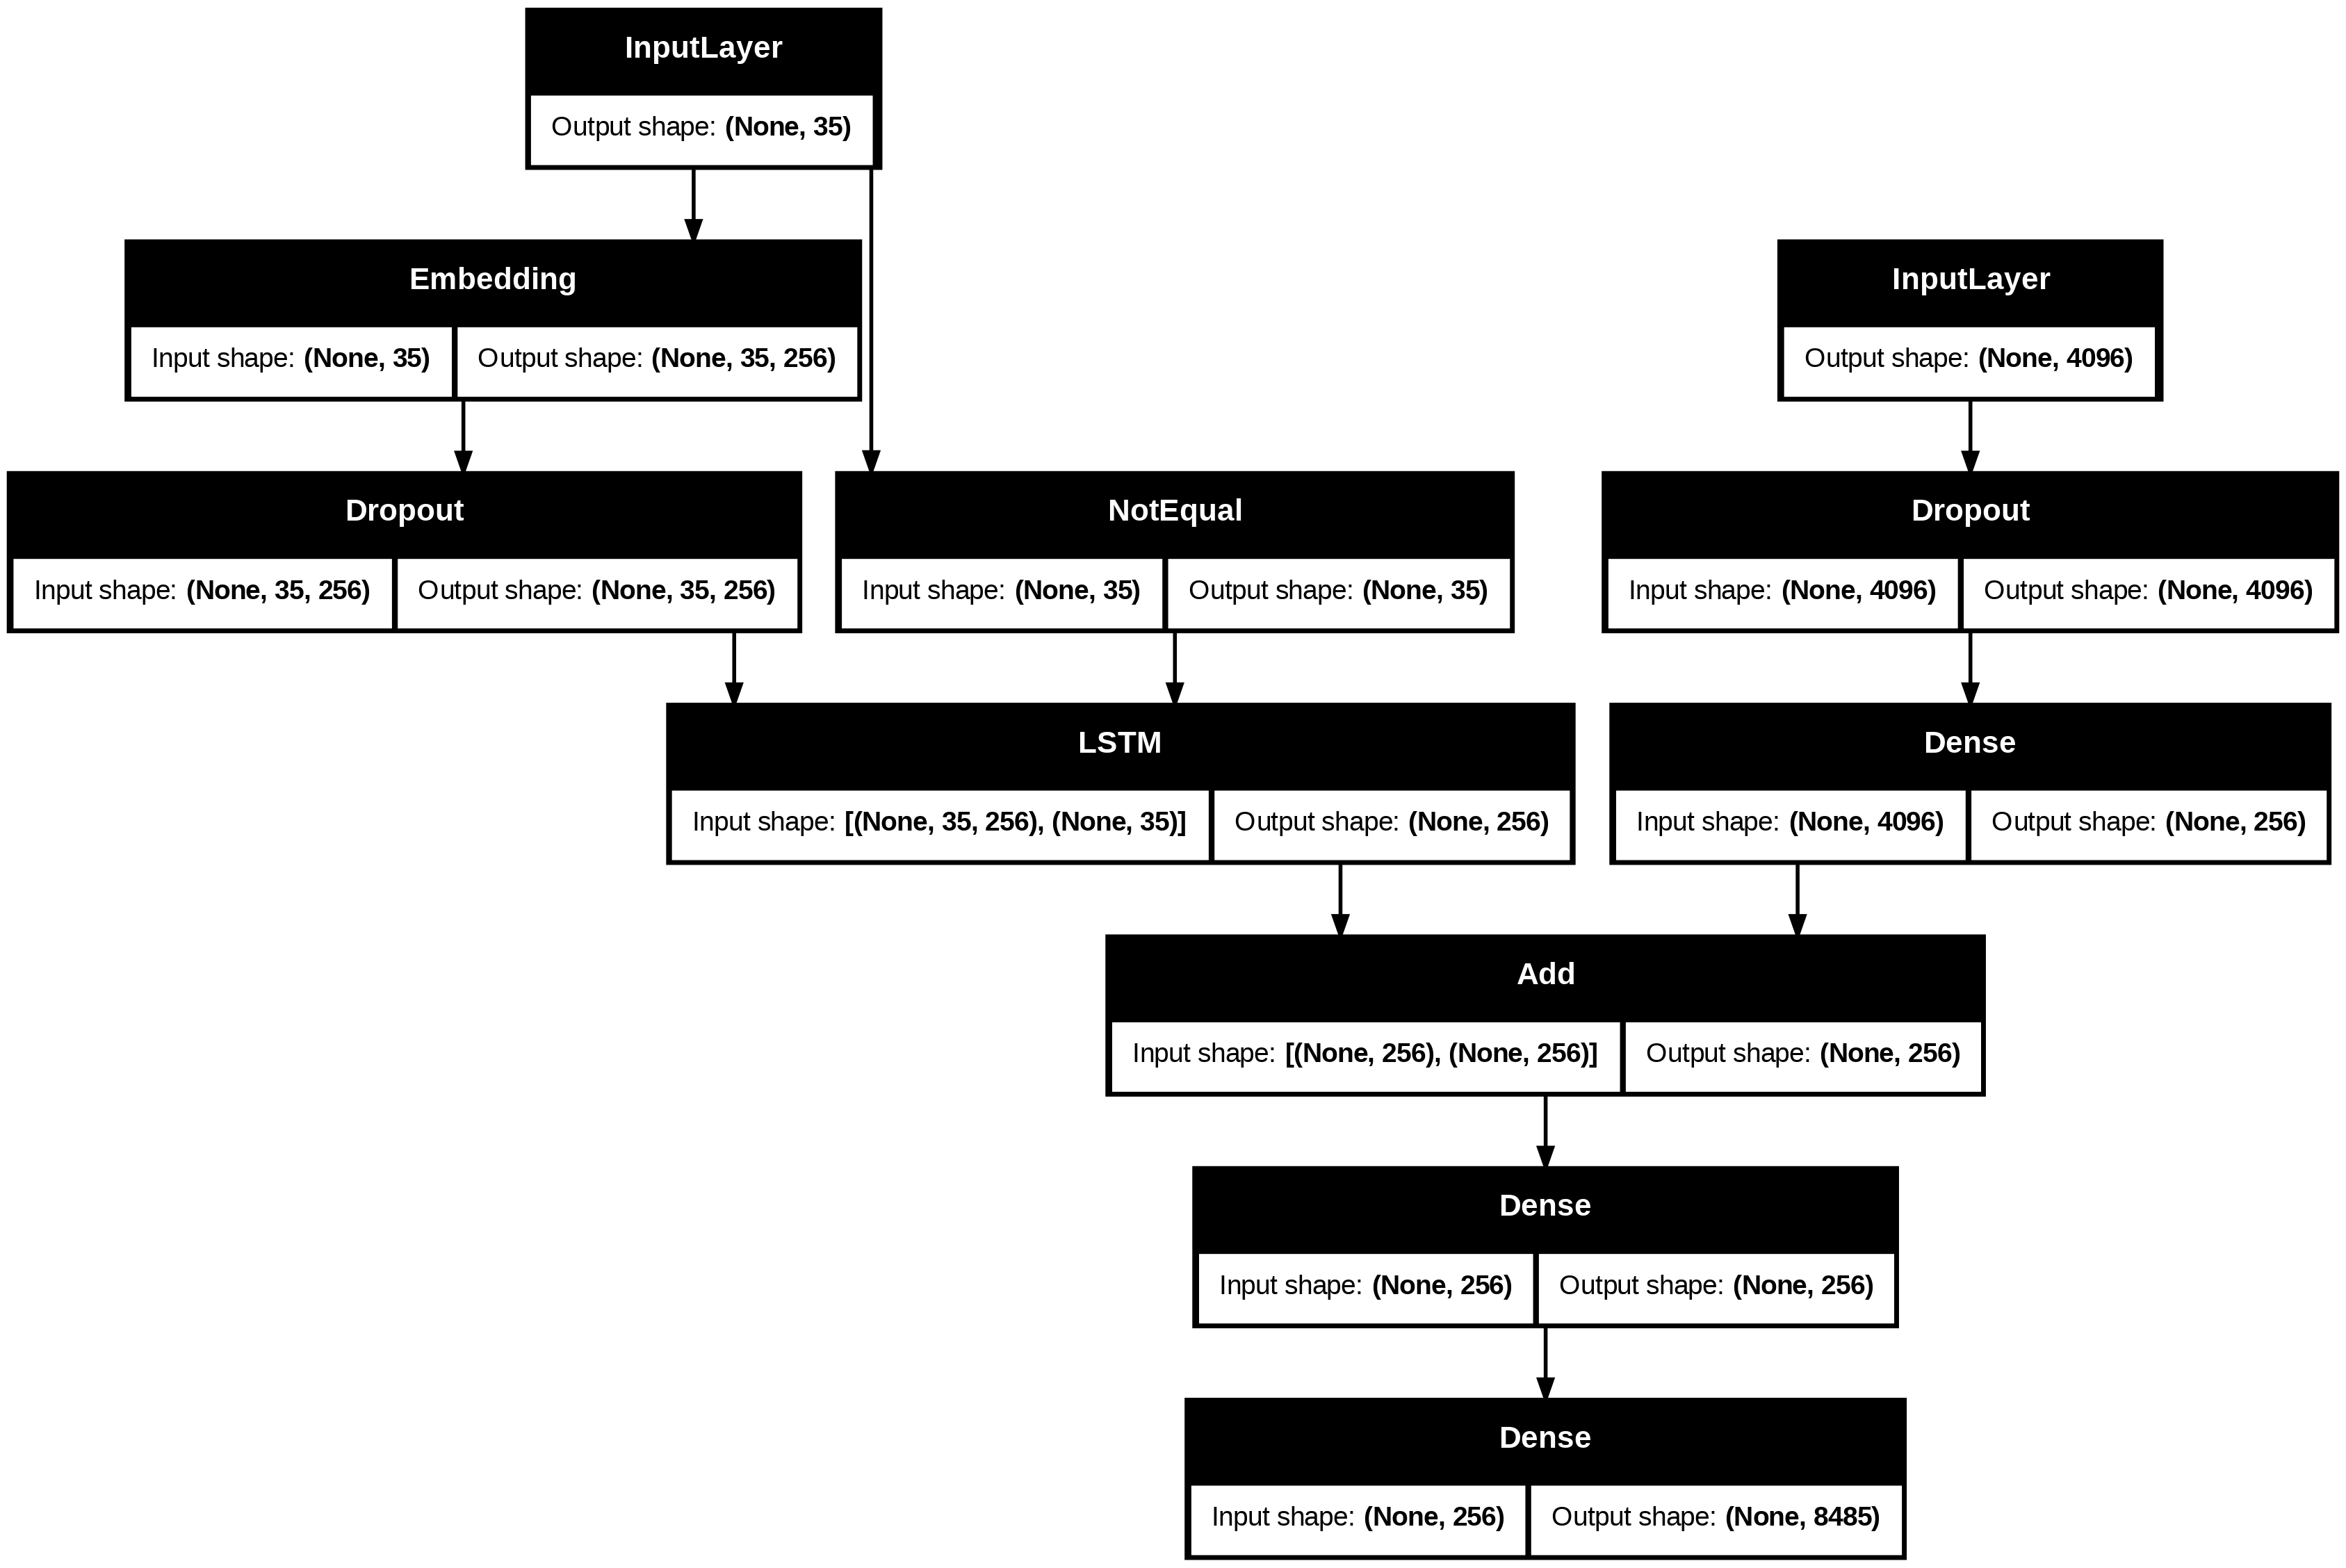

In [29]:
# Neural network model for image captioning using Keras.
# This model combines image features with text input to generate predictions for the next word in a caption.

inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [30]:
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 ━━━━━━━━━━━━━━━━━━━━ 64s 259ms/step - loss: 5.7965
227/227 ━━━━━━━━━━━━━━━━━━━━ 57s 251ms/step - loss: 4.0369
227/227 ━━━━━━━━━━━━━━━━━━━━ 59s 259ms/step - loss: 3.5677
227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 267ms/step - loss: 3.2932
227/227 ━━━━━━━━━━━━━━━━━━━━ 59s 259ms/step - loss: 3.0945
227/227 ━━━━━━━━━━━━━━━━━━━━ 59s 261ms/step - loss: 2.9456
227/227 ━━━━━━━━━━━━━━━━━━━━ 59s 261ms/step - loss: 2.8226
227/227 ━━━━━━━━━━━━━━━━━━━━ 69s 305ms/step - loss: 2.7279
227/227 ━━━━━━━━━━━━━━━━━━━━ 73s 324ms/step - loss: 2.6487
227/227 ━━━━━━━━━━━━━━━━━━━━ 59s 259ms/step - loss: 2.5809
227/227 ━━━━━━━━━━━━━━━━━━━━ 101s 446ms/step - loss: 2.5248
227/227 ━━━━━━━━━━━━━━━━━━━━ 108s 476ms/step - loss: 2.4689
227/227 ━━━━━━━━━━━━━━━━━━━━ 107s 473ms/step - loss: 2.4128
227/227 ━━━━━━━━━━━━━━━━━━━━ 134s 591ms/step - loss: 2.3673
227/227 ━━━━━━━━━━━━━━━━━━━━ 147s 649ms/step - loss: 2.3292
227/227 ━━━━━━━━━━━━━━━━━━━━ 126s 558ms/step - loss: 2.2858
227/227 ━━━━━━━━━━━━━━━━━━━━ 125s 554ms/step - los

In [31]:
model.save('my_model.h5')

In [32]:
# converts an integer (word index) back to its corresponding word using the tokenizer's word index.
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
          return word
    return None

In [33]:
# The predict_caption() function is designed to generate a caption for a given image using a trained image captioning model.
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'caption'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length, padding='post')
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [34]:
# calculates the BLEU score (Bilingual Evaluation Understudy) for evaluating the performance of the image captioning model.
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    # calcuate BLEU score
    print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BLEU-1: 0.428571
BLEU-2: 0.181568
BLEU-1: 0.407407
BLEU-2: 0.221108
BLEU-1: 0.410256
BLEU-2: 0.238705
BLEU-1: 0.448980
BLEU-2: 0.264275
BLEU-1: 0.424242
BLEU-2: 0.235878
BLEU-1: 0.413333
BLEU-2: 0.218913
BLEU-1: 0.430233
BLEU-2: 0.233366
BLEU-1: 0.432990
BLEU-2: 0.220569
BLEU-1: 0.428571
BLEU-2: 0.221601
BLEU-1: 0.443478
BLEU-2: 0.225129
BLEU-1: 0.450820
BLEU-2: 0.238454
BLEU-1: 0.434783
BLEU-2: 0.219793
BLEU-1: 0.449664
BLEU-2: 0.230004
BLEU-1: 0.429448
BLEU-2: 0.214745
BLEU-1: 0.431034
BLEU-2: 0.208266
BLEU-1: 0.420213
BLEU-2: 0.197711
BLEU-1: 0.430693
BLEU-2: 0.204708
BLEU-1: 0.441315
BLEU-2: 0.218005
BLEU-1: 0.444444
BLEU-2: 0.217865
BLEU-1: 0.451064
BLEU-2: 0.224391
BLEU-1: 0.444882
BLEU-2: 0.218481
BLEU-1: 0.441509
BLEU-2: 0.217347
BLEU-1: 0.448905
BLEU-2: 0.231633
BLEU-1: 0.454225
BLEU-2: 0.243718
BLEU-1: 0.459732
BLEU-2: 0.249616
BLEU-1: 0.459016
BLEU-2: 0.253305
BLEU-1: 0.456869
BLEU-2: 0.249600
BLEU-1: 0.452308
BLEU-2: 0.243709
BLEU-1: 0.458084
BLEU-2: 0.242022
BLEU-1: 0.4582

In [35]:
from PIL import Image
import matplotlib.pyplot as plt

# The function generate_caption() is designed to load an image, retrieve its actual captions from the mapping,
# predict a caption using the trained model,
# and then display both the actual and predicted captions along with the image.

def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('/')[-1].split('.')[0]
    img_path = os.path.join('/content' ,"Images", image_name.split('/')[-1])
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
Caption: woman dressed in blue jacket and blue jeans rides brown horse near frozen lake and snow-covered mountain endseq
Caption: woman in blue jacket rides brown pony near water endseq
Caption: woman rides horse near frozen lake in the wintertime endseq
Caption: young blond woman sitting atop brown draft horse in the snowy mountains endseq
Caption: woman blue jacket sits on daft horse near frozen lake endseq
--------------------Predicted--------------------
caption man in yellow dress is playing with brown dog on daft beach endseq


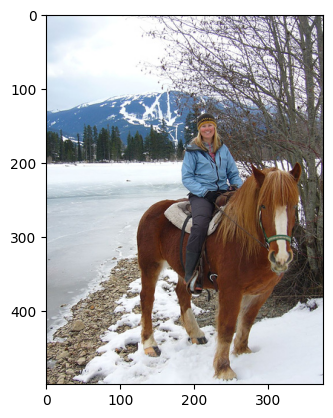

In [36]:
generate_caption("/content/Images/109202756_b97fcdc62c.jpg")

In [37]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs,
                  outputs=vgg_model.layers[-2].output)

In [38]:
image_path = '/content/Images/1015118661_980735411b.jpg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image from vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_32']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


'caption two children are walking down stone road endseq'

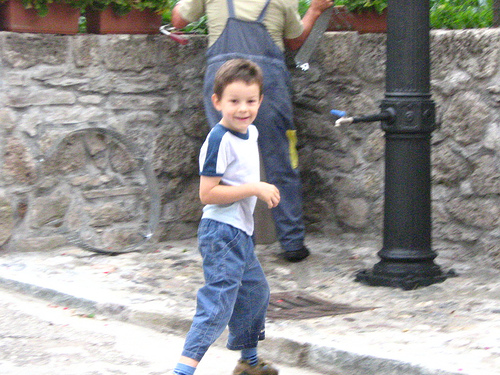

In [39]:
display(Image.open(image_path))

In [40]:
image_text  = pipeline("image-to-text",model="Salesforce/blip-image-captioning-large")
caption1=image_text(image_path)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/527 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


In [41]:
caption1

[{'generated_text': 'there is a young boy riding a skateboard down the street'}]

In [42]:
print(
    '''
    Choose the language from below, to generate the caption:
    1. English
    2. Malayalam
    3. German
    4. Hindi
    5. French
    6. Dutch

    '''
)
choice = int(input("Enter your choice: "))
if choice ==1:
  print(caption1)
elif choice==2:
  trans = pipeline("translation",model="Helsinki-NLP/opus-mt-en-ml")
  print(trans(caption1[0]['generated_text']))
elif choice==3:
  trans=trans = pipeline("translation",model="Helsinki-NLP/opus-mt-en-de")
  print(trans(caption1[0]['generated_text']))
elif choice==4:
  trans = pipeline("translation",model="Helsinki-NLP/opus-mt-en-hi")
  print(trans(caption1[0]['generated_text']))
elif choice==5:
  trans = pipeline("translation",model="Helsinki-NLP/opus-mt-en-fr")
  print(trans(caption1[0]['generated_text']))
elif choice==6:
  trans = pipeline("translation",model="Helsinki-NLP/opus-mt-en-nl")
  print(trans(caption1[0]['generated_text']))


    Choose the language from below, to generate the caption:
    1. English
    2. Malayalam
    3. German
    4. Hindi
    5. French
    6. Dutch

    
Enter your choice: 2


config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/229M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/229M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/449k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/614k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/956k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Device set to use cuda:0


[{'translation_text': 'അവിടെ ഒരു ചെറുപ്പക്കാരൻ തെരുവിൽ ഒരു സ്കേറ്റ് ബോർഡ് ഓടിക്കുന്നു.'}]


In [43]:
'''
def image_text(image_path):
   return caption1
def translate_caption(image_path, language_choice):
    if language_choice == 1:
        return caption1
    elif language_choice == 2:
        trans = pipeline("translation",model="Helsinki-NLP/opus-mt-en-ml")
        #return trans(caption1[0]['generated_text'])
    elif language_choice == 3:
        trans=trans = pipeline("translation",model="Helsinki-NLP/opus-mt-en-de")
        #return trans(caption1[0]['generated_text'])
    elif language_choice == 4:
        trans = pipeline("translation",model="Helsinki-NLP/opus-mt-en-hi")
        #return trans(caption1[0]['generated_text'])
    elif language_choice == 5:
        trans = pipeline("translation",model="Helsinki-NLP/opus-mt-en-fr")
        #return trans(caption1[0]['generated_text'])
    elif language_choice == 6:
        trans = pipeline("translation",model="Helsinki-NLP/opus-mt-en-nl")
        #return trans(caption1[0]['generated_text'])
    translated_caption = trans(caption)[0]['translation_text']
    return translated_caption

# Gradio UI
iface = gr.Interface(
    fn=translate_caption,
    inputs=[
        gr.Image(type="filepath", label="Upload Image"),  # Image input
        gr.Radio(["English", "Malayalam", "German", "Hindi", "French", "Dutch"], label="Select Language")  # Language selection
    ],
    outputs="text",
    title="Image Caption Generator",
    description="Upload an image, choose a language, and get an AI-generated caption.",
)

# Launch the app
iface.launch()
'''

# Load the image captioning pipeline
image_to_text = pipeline("image-to-text", model="Salesforce/blip-image-captioning-large")

# Function to generate caption from image
def generate_caption(image_path):
    # Generate caption using the image-to-text pipeline
    caption = image_to_text(image_path)
    return caption[0]['generated_text']

# Function to translate caption
def translate_caption(caption, language_choice):
    if language_choice == "English":
        return caption
    elif language_choice == "Malayalam":
        trans = pipeline("translation_en_to_ml", model="Helsinki-NLP/opus-mt-en-ml")
    elif language_choice == "German":
        trans = pipeline("translation_en_to_de", model="Helsinki-NLP/opus-mt-en-de")
    elif language_choice == "Hindi":
        trans = pipeline("translation_en_to_hi", model="Helsinki-NLP/opus-mt-en-hi")
    elif language_choice == "French":
        trans = pipeline("translation_en_to_fr", model="Helsinki-NLP/opus-mt-en-fr")
    elif language_choice == "Dutch":
        trans = pipeline("translation_en_to_nl", model="Helsinki-NLP/opus-mt-en-nl")
    else:
        return "Unsupported language"

    # Translate the caption
    translated_caption = trans(caption)[0]['translation_text']
    return translated_caption

# Main function for Gradio app
def caption_and_translate(image, language_choice):
    # Generate the caption in English
    caption = generate_caption(image)
    # Translate the caption to the selected language
    translated_caption = translate_caption(caption, language_choice)
    return translated_caption

# Gradio interface
iface = gr.Interface(
    fn=caption_and_translate,
    inputs=[
        gr.Image(type="filepath", label="Upload Image"),  # Image input
        gr.Radio(["English", "Malayalam", "German", "Hindi", "French", "Dutch"], label="Select Language")  # Language selection
    ],
    outputs="text",
    title="Multi-lingual Image Caption Generator",
    description="Upload an image and generate captions in multiple languages!",
    examples=[
        ["/content/Images/109202756_b97fcdc62c.jpg", "English"],
        ["/content/Images/1015118661_980735411b.jpg", "Hindi"]
    ],
    theme="dark",
)

# Launch the app
iface.launch()

Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/gradio/blocks.py:1096: UserWarning: Cannot load dark. Caught Exception: 404 Client Error: Not Found for url: https://huggingface.co/api/spaces/dark (Request ID: Root=1-67ba0fd5-52fbc8b41d926f4121d093c9;dc5fc97c-ed9d-45b8-84b7-3097e048a8e0)

Sorry, we can't find the page you are looking for.
  warnings.warn(f"Cannot load {theme}. Caught Exception: {str(e)}")


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e560e40c4b160d4eb4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [44]:
''''
import gradio as gr
from transformers import pipeline

# Function to generate a dummy caption (Replace this with actual captioning model)
def image_text(image_path):
   return "caption1"  # Replace with actual caption model

# Translation function
def translate_caption(image_path, language_choice):
    caption = generate_caption(image_path)  # Generate the caption in English

    # Language models mapping
    language_map = {
        "English": None,
        "Malayalam": "Helsinki-NLP/opus-mt-en-ml",
        "German": "Helsinki-NLP/opus-mt-en-de",
        "Hindi": "Helsinki-NLP/opus-mt-en-hi",
        "French": "Helsinki-NLP/opus-mt-en-fr",
        "Dutch": "Helsinki-NLP/opus-mt-en-nl",
    }

    if language_choice == "English":
        return caption  # No translation needed

    # Perform translation
    translator = pipeline("translation", model=language_map[language_choice])
    translated_caption = translator(caption)[0]['translation_text']
    return translated_caption

# Gradio UI
iface = gr.Interface(
    fn=translate_caption,
    inputs=[
        gr.Image(type="filepath", label="Upload Image"),  # Image input
        gr.Radio(["English", "Malayalam", "German", "Hindi", "French", "Dutch"], label="Select Language")  # Language selection
    ],
    outputs="text",
    title="Image Caption Generator",
    description="Upload an image, choose a language, and get an AI-generated caption.",
)

# Launch the app
iface.launch()
'''

'\'\nimport gradio as gr\nfrom transformers import pipeline\n\n# Function to generate a dummy caption (Replace this with actual captioning model)\ndef image_text(image_path):\n   return "caption1"  # Replace with actual caption model\n\n# Translation function\ndef translate_caption(image_path, language_choice):\n    caption = generate_caption(image_path)  # Generate the caption in English\n\n    # Language models mapping\n    language_map = {\n        "English": None,\n        "Malayalam": "Helsinki-NLP/opus-mt-en-ml",\n        "German": "Helsinki-NLP/opus-mt-en-de",\n        "Hindi": "Helsinki-NLP/opus-mt-en-hi",\n        "French": "Helsinki-NLP/opus-mt-en-fr",\n        "Dutch": "Helsinki-NLP/opus-mt-en-nl",\n    }\n\n    if language_choice == "English":\n        return caption  # No translation needed\n\n    # Perform translation\n    translator = pipeline("translation", model=language_map[language_choice])\n    translated_caption = translator(caption)[0][\'translation_text\']\n    r